# Data Visualization Society | State of the Industry Survey 2021

This notebook contains exploratory analysis for the SOTI Survey 2021 conducted by the Data Visualization Society.

More information and the original data can be found [here](https://docs.google.com/spreadsheets/d/1lDkxioTmT5--JufJuYryiV5fKsdQQopvlSJO4Gh0ors/edit#gid=1462100456).

## Setup

In [1]:
# Import libraries
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [2]:
def read_gdrive_csv(url, *args, **kwargs) -> pd.DataFrame:
    """Read csv file from public Google Drive."""
    url='https://drive.google.com/uc?id=' + url.split('/')[-2]
    df = pd.read_csv(url, *args, **kwargs)
    df.rename(columns=dict(zip(df.columns, list(map(lambda x: x.lower(), df.columns)))), inplace=True)  # lowercase
    return df

In [3]:
job_task = read_gdrive_csv("https://drive.google.com/file/d/1WupRj5C2feB_JfkqmT8_8Gz3t0AhqMrD/view?usp=sharing")
main = read_gdrive_csv("https://drive.google.com/file/d/1d7AbbV4IrECFI9t5Ri4WiPrqyMYqsv__/view?usp=sharing", dtype=object)

## Analyzing Jobs and Tasks
_A day in the life of a data visualist..._

In [4]:
job_task.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   jobtitle__lightlycleaned   1952 non-null   object
 1   rolemultichoice_composite  1890 non-null   object
 2   timeworked                 2158 non-null   object
 3   timedataprep               2113 non-null   object
 4   timedataanalysis           2111 non-null   object
 5   timeideating               2080 non-null   object
 6   timeproducingviz           2129 non-null   object
 7   timeotherviztasks          1859 non-null   object
 8   otherviztasks__            715 non-null    object
 9   altid                      2165 non-null   int64 
dtypes: int64(1), object(9)
memory usage: 169.3+ KB


### What is your role?

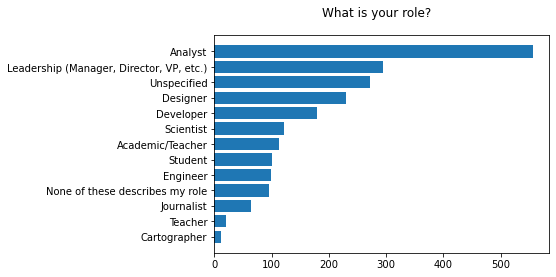

In [5]:
df = job_task.copy()
df["rolemultichoice_composite"] = df["rolemultichoice_composite"].fillna("Unspecified")
df = pd.DataFrame(df.groupby(["rolemultichoice_composite"]).count().iloc[:,1])
df = df.sort_values(by=df.columns[0], ascending=True)

fig, ax = plt.subplots()
fig.suptitle("What is your role?")
ax.barh(y=df.index, width=df.iloc[:,0])
plt.show()

### Q03-04 How much time do you spend on tasks?

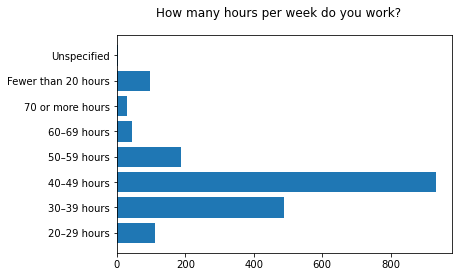

In [6]:
df = job_task.copy()
df["timeworked"] = df["timeworked"].fillna("Unspecified")
df = pd.DataFrame(df.groupby(["timeworked"]).count().iloc[:,1])

fig, ax = plt.subplots()
fig.suptitle("How many hours per week do you work?")
ax.barh(y=df.index, width=df.iloc[:,0])
plt.show()

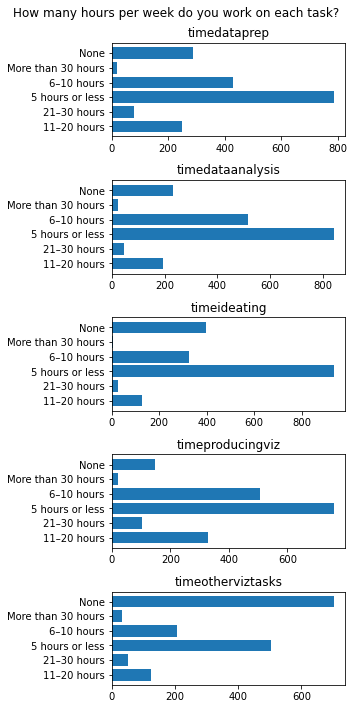

In [7]:
columns = ['timedataprep','timedataanalysis','timeideating','timeproducingviz','timeotherviztasks']
name_sort = {key: value for value, key in enumerate(["None", "5hoursorless", "6–10hours", "11–20hours", "21-30hours", "Morethan30hours"])}

fig, axes = plt.subplots(5, 1, figsize=[5,10])
fig.suptitle("How many hours per week do you work on each task?")
for i, col in enumerate(columns):
    df = job_task.copy()
    # df[col] = df[col].map(lambda x: re.sub(r"[\n\t\s]*","",str(x)))
    # df["name_sort"] = df[col].map(name_sort)
    # df = df.sort_values(by=["name_sort"], ascending=True)
    df = pd.DataFrame(df.groupby([col]).count().iloc[:, 1])
    
    ax = axes[i]
    ax.set_title(col)
    ax.barh(y=df.index, width=df.iloc[:,0])

fig.tight_layout()
plt.show()

### Q05 What else do you do?

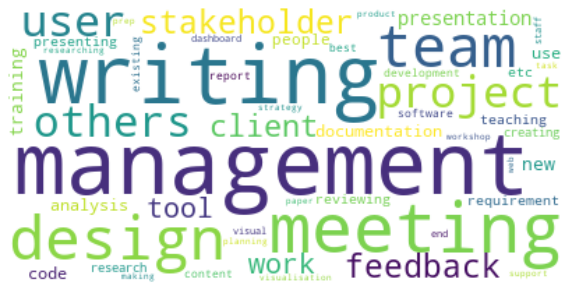

In [8]:
df = job_task.copy()
df["otherviztasks__"] = df["otherviztasks__"].str.lower()

# Set stopwords for wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["visualization", "visualizations", "data", "dataviz", "viz"])

fig, ax = plt.subplots(figsize=(10,6))
text = "".join(str(each) for each in df["otherviztasks__"]) # Create text
wordcloud = WordCloud(max_words=50, background_color="white", stopwords = stopwords) # Generate word cloud image
wordcloud.generate(text) # Generate word cloud text
ax.imshow(wordcloud, interpolation='bilinear'); # Display the generated image:
ax.axis("off");

plt.show();

The data from Jobs & Tasks is not variable enough. For example, the distribution shape of each data visualization related task is roughly the same. Most people have 40 hour work weeks. 

## Analyzing Main data

Roughly 1,500 survey responses came from people who are employees. We'll only look at these people.

In [9]:
# Filter to employees
main = main[~main.dvroles_employee.isna()]

## Q18-19 Who are the employees?

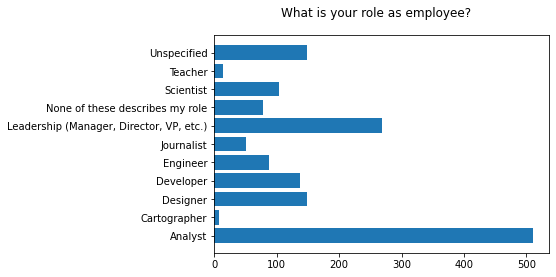

In [10]:
df = main.copy()
df["roleasemployee"] = df["roleasemployee"].fillna("Unspecified")
df = pd.DataFrame(df.groupby(["roleasemployee"]).count().iloc[:,1])

fig, ax = plt.subplots()
fig.suptitle("What is your role as employee?")
ax.barh(y=df.index, width=df.iloc[:,0])
plt.show()

Categories to consolidate:
* Analyst: analyst
* Designer: designer, cartographer
* Engineer: engineer, developer, scientist
* Journalist: journalist, teacher
* Manager: leadership
* Other: unspecified, none

In [11]:
def consolidate_roles(role: str) -> str: 
    """Consolidate roles."""
    if role in ["Analyst"]:
        return "Analyst"
    elif role in ["Designer", "Cartographer"]:
        return "Designer"
    elif role in ["Engineer", "Developer", "Scientist"]:
        return "Engineer"
    elif role in ["Journalist", "Teacher"]:
        return "Journalist"
    elif "Leadership" in role:
        return "Manager"
    else:
        return "Other"

main["roleasemployee"] = main["roleasemployee"].fillna("Unspecified")
main["role"] = main["roleasemployee"].apply(lambda x: consolidate_roles(x))

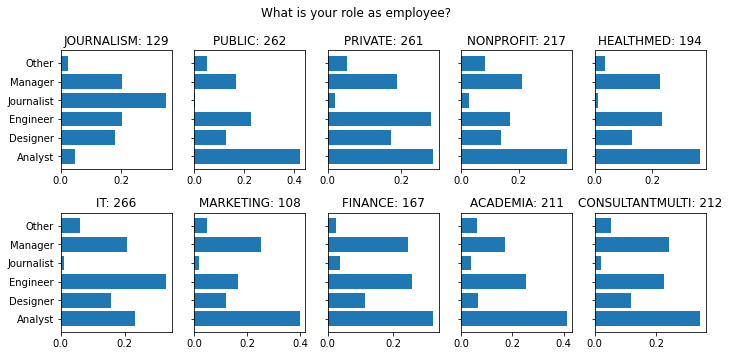

In [12]:
ORGS = ["journalism", "public", "private", "nonprofit", "healthmed", "it", "marketing", "finance", "academia", "consultantmulti"]

fig, axes = plt.subplots(2, 5, figsize=[10,5])
axes = axes.flatten()
for i, o in enumerate(ORGS):
    df = main.copy()
    df = df[~df["orgsector_" + o].isna()]
    df = df.sort_values(by="role", ascending=False)
    ax = axes[i]
    ax.set(title=o.upper() + ": " + str(df.shape[0]))
    
    df = pd.DataFrame(df.groupby(["role"]).count().iloc[:,1]).reset_index()
    df.columns = ["role", "volume"]
    df.volume = df.volume / df.volume.sum()
    ax.barh(y=df.role, width=df.volume)
    if i not in [0, 5]:
        ax.set_yticklabels([])
    
fig.suptitle("What is your role as employee?")
fig.tight_layout()
plt.show()

The org sectors are nicely distributed and make a good segment for visualization. The variability between roles within each org sector is informative:
* Most industries except journalism have majority analysts.
* Most orgs have leadership, engineers, and analysts doing DV. Journalism has journalists.
* Public orgs have majority analysts doing data visualization. In private orgs, other roles have to flex into data visualization as well. IE: In private sector, roles are more flexible.
* In IT, many people who do DV are engineers rather than analysts. Designers have more DV work in IT and private.
* Visualizations in academia is driven by analysts instead of leadership.

## Q06-07 How many years of experience?

In [13]:
# Map YOE text to numerical
YOE_TO_NUM = {
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6–10": 8,
    "11–15": 13,
    "16–20": 18,
    "21–25": 23,
    "26–30": 28,
    "More than 30": 35,
    "Less than 1 year": 0.5,
}

def map_col_to_num(mapping: dict, col_str: str) -> float:
    """Use regex to map column's string value to numerical."""
    keys = list(mapping.keys())
    keys.reverse()
    for lookup in keys:
        if re.search(lookup, col_str) != None:
            return mapping[lookup]
    return -1

def format_yoe(df):
    """Format YOE data."""
    # Fill na
    df["yearsdvexperience"] = df["yearsdvexperience"].fillna("Unspecified")
    df["yearsworkexperience"] = df["yearsworkexperience"].fillna("Unspecified")
    # Map values
    df["dv_yoe"] = df["yearsdvexperience"].map(lambda x: map_col_to_num(YOE_TO_NUM, x))
    df["work_yoe"] = df["yearsworkexperience"].map(lambda x: map_col_to_num(YOE_TO_NUM, x))
    return df

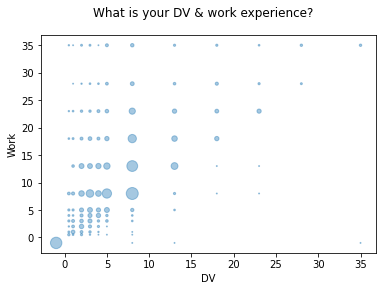

In [14]:
# Format data
df = main.copy()
df = format_yoe(df)

df = df.groupby(["dv_yoe", "work_yoe"]).count().iloc[:,0].reset_index()
df.columns = ["dv_yoe", "work_yoe", "volume"]

fig, ax = plt.subplots()
fig.suptitle("What is your DV & work experience?")
ax.scatter(x=df.dv_yoe, y=df.work_yoe, s=df.volume, alpha=0.4)
ax.set(xlabel="DV", ylabel="Work")
plt.show()

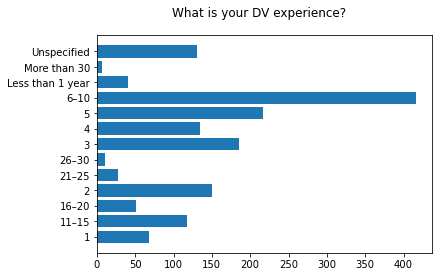

In [15]:
df = main.copy()
df["yearsdvexperience"] = df["yearsdvexperience"].fillna("Unspecified")
df = pd.DataFrame(df.groupby(["yearsdvexperience"]).count().iloc[:,1])

fig, ax = plt.subplots()
fig.suptitle("What is your DV experience?")
ax.barh(y=df.index, width=df.iloc[:,0])
plt.show()

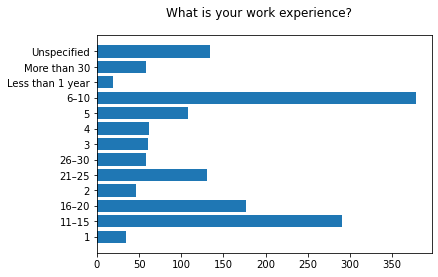

In [16]:
df = main.copy()
df["yearsworkexperience"] = df["yearsworkexperience"].fillna("Unspecified")
df = pd.DataFrame(df.groupby(["yearsworkexperience"]).count().iloc[:,1])

fig, ax = plt.subplots()
fig.suptitle("What is your work experience?")
ax.barh(y=df.index, width=df.iloc[:,0])
plt.show()

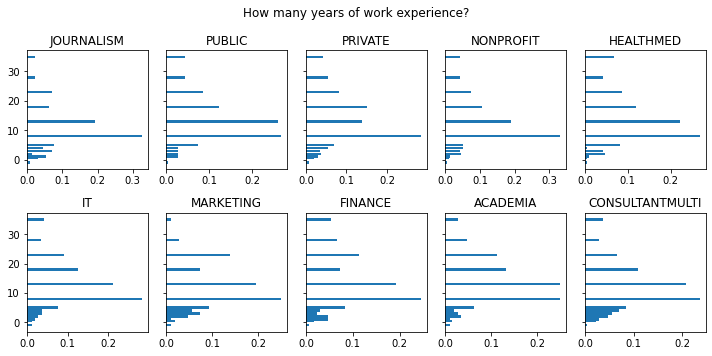

In [17]:
fig, axes = plt.subplots(2, 5, figsize=[10,5])
axes = axes.flatten()
for i, o in enumerate(ORGS):
    df = main.copy()
    df = df[~df["orgsector_" + o].isna()]
    df = format_yoe(df)
    ax = axes[i]
    ax.set(title=o.upper())
    
    df = pd.DataFrame(df.groupby(["work_yoe"]).count().iloc[:,1]).reset_index()
    df.columns = ["work_yoe", "volume"]
    df.volume = df.volume / df.volume.sum()
    ax.barh(y=df.work_yoe, width=df.volume)
    if i not in [0, 5]:
        ax.set_yticklabels([])
    
fig.suptitle("How many years of work experience?")
fig.tight_layout()
plt.show()

## Q09 What is the compensation?

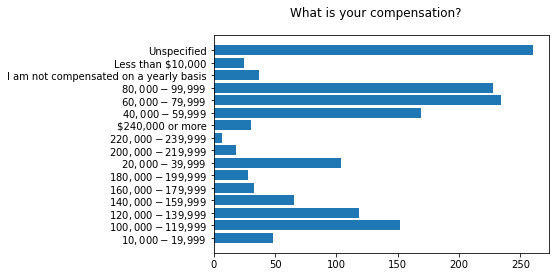

In [18]:
df = main.copy()
df["payannual"] = df["payannual"].fillna("Unspecified")
df = pd.DataFrame(df.groupby(["payannual"]).count().iloc[:,1])

fig, ax = plt.subplots()
fig.suptitle("What is your compensation?")
ax.barh(y=df.index, width=df.iloc[:,0])
plt.show()

In [19]:
# Map Compensation text to numerical
COMP_TO_NUM = {
    "Less than $10,000": 5,
    "99,999": 90,
    "79,999": 70,
    "59,999": 50,
    "240,000": 250,
    "239,999": 230,
    "219,999": 210,
    "39,999": 30,
    "199,999": 190,
    "179,999": 170,
    "159,999": 150,
    "139,999": 130,
    "119,999": 110,
    "19,999": 10,
}

def format_comp(df):
    """Format YOE data."""
    # Fill na
    df["payannual"] = df["payannual"].fillna("Unspecified")
    # Map values
    df["salary"] = df["payannual"].map(lambda x: map_col_to_num(COMP_TO_NUM, x))
    return df

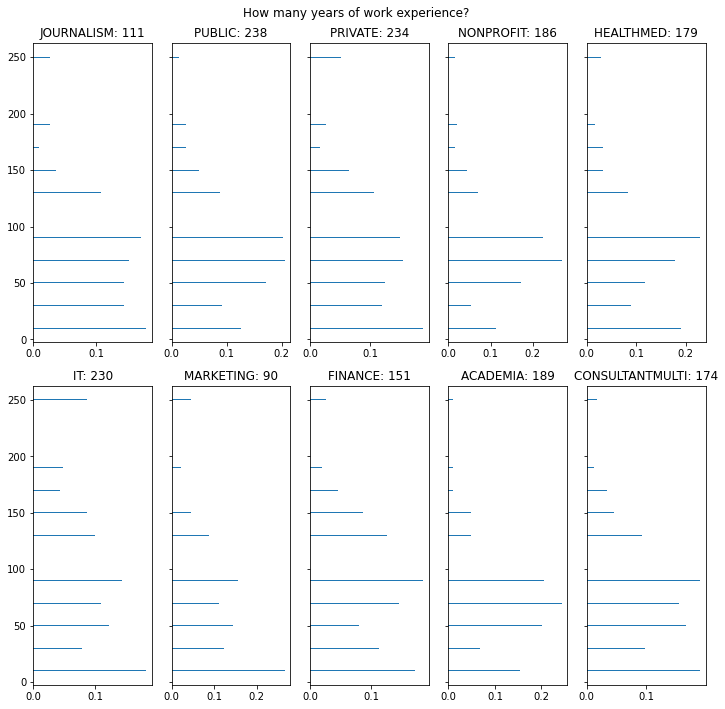

In [20]:
fig, axes = plt.subplots(2, 5, figsize=[10,10])
axes = axes.flatten()
for i, o in enumerate(ORGS):
    df = main.copy()
    # df = df[df.paycurrency_cleaned == "USD - US Dollar"]
    df = df[~df["orgsector_" + o].isna()]
    df = format_comp(df)
    df = df[df.salary > 0]
    ax = axes[i]
    ax.set(title=o.upper() + ": " + str(df.shape[0]))
    
    df = pd.DataFrame(df.groupby(["salary"]).count().iloc[:,1]).reset_index()
    df.columns = ["salary", "volume"]
    df.volume = df.volume / df.volume.sum()
    ax.barh(y=df.salary, width=df.volume)
    if i not in [0, 5]:
        ax.set_yticklabels([])
    
fig.suptitle("How many years of work experience?")
fig.tight_layout()
plt.show()

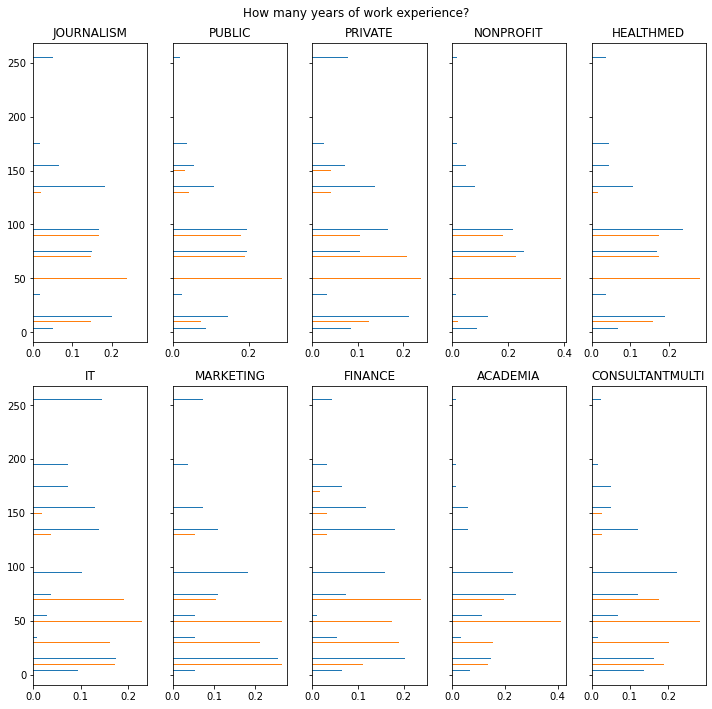

In [21]:
# color coded by US/international because payscale is significantly different
fig, axes = plt.subplots(2, 5, figsize=[10,10])
axes = axes.flatten()
for i, o in enumerate(ORGS):
    ax = axes[i]
    ax.set(title=o.upper())
    
    for f in [1, 2]:
        df = main.copy()
        df = df[~df["orgsector_" + o].isna()]
        df = format_comp(df)
        if f == 1:
            df = df[df.paycurrency_cleaned == "USD - US Dollar"]
            df.salary = df.salary+5
        else:
            df = df[df.paycurrency_cleaned != "USD - US Dollar"]
        
        df = df[df.salary > 0]


        df = pd.DataFrame(df.groupby(["salary"]).count().iloc[:,1]).reset_index()
        df.columns = ["salary", "volume"]
        df.volume = df.volume / df.volume.sum()
        ax.barh(y=df.salary, width=df.volume)
    
    if i not in [0, 5]:
        ax.set_yticklabels([])
    
fig.suptitle("How many years of work experience?")
fig.tight_layout()
plt.show()

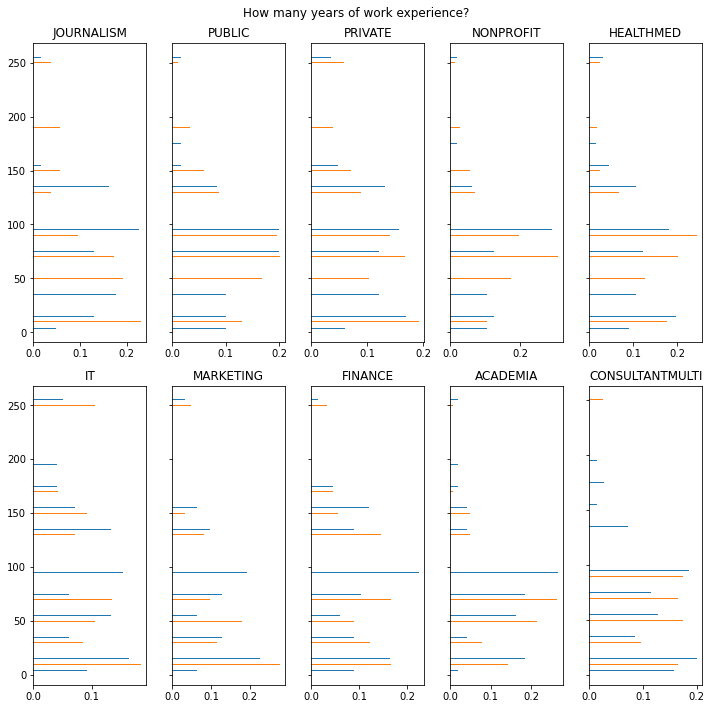

In [22]:
# color coded by DV centrality
main["dvcentralityemployee"] = main["dvcentralityemployee"].fillna("")
main["is_primary_dv"] = main["dvcentralityemployee"].apply(lambda x: True if "Data visualization is the primary focus of my job" in x else False)


fig, axes = plt.subplots(2, 5, figsize=[10,10])
axes = axes.flatten()
for i, o in enumerate(ORGS):
    ax = axes[i]
    ax.set(title=o.upper())
    
    for f in [1, 2]:
        df = main.copy()
        df = df[~df["orgsector_" + o].isna()]
        df = format_comp(df)
        if f == 1:
            df = df[df.is_primary_dv]
            df.salary = df.salary+5
        else:
            df = df[~df.is_primary_dv]
        
        df = df[df.salary > 0]


        df = pd.DataFrame(df.groupby(["salary"]).count().iloc[:,1]).reset_index()
        df.columns = ["salary", "volume"]
        df.volume = df.volume / df.volume.sum()
        ax.barh(y=df.salary, width=df.volume)
    
    if i not in [0, 5]:
        ax.set_yticklabels([])
    
fig.suptitle("How many years of work experience?")
fig.tight_layout()
plt.show()

Color code by whether DV is primary focus. There is enough variability between the two, and it's more interesting than seeing it by US/other countries.

## Format data

Overall Steps:
1. Consolidate employee role
2. Convert DV centrality to boolean
3. Convert work YOE and compensation to numerical
4. Stack Org Sectors
5. Drop null
6. Aggregate by segments

In [23]:
df = main[main.chronid.isna()]
df["org"] = ""
for org in ORGS:
    p = main[~main["orgsector_" + org].isna()]
    # Rename orgs for nicer names
    if org == "nonprofit":
        org = "non-profit"
    elif org == "healthmed":
        org = "health"
    elif org == "consultantmulti":
        org = "consulting"
    p["org"] = org
    
    df = pd.concat([df, p])
    
df = format_comp(df)
df = format_yoe(df)
df = df[["role", "is_primary_dv", "salary", "work_yoe", "org"]]

df.head()

/var/folders/qf/dsrk08sd51dcgwp2fp8wpt8w0000gn/T/ipykernel_25872/3445238691.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p["org"] = org


,role,is_primary_dv,salary,work_yoe,org
4,Engineer,False,50,13.0,journalism
13,Engineer,False,-1,5.0,journalism
19,Other,False,-1,1.0,journalism
35,Journalist,False,50,0.5,journalism
36,Designer,False,50,1.0,journalism


In [24]:
# For YOE
yoe = df.groupby(["org", "role", "is_primary_dv", "work_yoe"]).count().iloc[:,0].reset_index()
yoe.columns = ["org", "role", "primary", "yoe", "yoeVolume"]
yoe = yoe[yoe["yoe"]>0]

# For Comp
comp = df.groupby(["org", "role", "is_primary_dv", "salary"]).count().iloc[:,0].reset_index()
comp.columns = ["org", "role", "primary", "salary", "salaryVolume"]
comp = comp[comp["salary"]>0]

# For Aggregate of role
agg = df.groupby(["org", "role", "is_primary_dv"]).count().iloc[:,0].reset_index()
agg.columns = ["org", "role", "primary", "volume"]

In [25]:
# Convert to percent of total
yoe_sum = yoe.groupby(["org", "role"]).sum()[["yoeVolume"]].reset_index()
yoe_sum.columns = ["org", "role", "yoeTotalVolume"]
yoe = pd.merge(yoe, yoe_sum, how="inner", on=["org", "role"])
yoe["yoePctVolume"] = yoe["yoeVolume"] / yoe["yoeTotalVolume"]

comp_sum = comp.groupby(["org", "role"]).sum()[["salaryVolume"]].reset_index()
comp_sum.columns = ["org", "role", "salaryTotalVolume"]
comp = pd.merge(comp, comp_sum, how="inner", on=["org", "role"])
comp["salaryPctVolume"] = comp["salaryVolume"] / comp["salaryTotalVolume"]

In [26]:
# Create spine for YOE and Comp
# Cross join org x role x primary x (yoe/comp)

orgs = list(yoe.org.unique())
orgs.sort()
roles = list(yoe.role.unique())
roles.sort()
primary = list(yoe.primary.unique())
primary.sort()

yoes = list(yoe.yoe.unique()) + [-1] + [38]
yoes.sort()
comps = list(comp.salary.unique()) + [-1] + [270]
comps.sort()

orgs_df = pd.DataFrame(orgs)
orgs_df["join"] = 1
roles_df = pd.DataFrame(roles)
roles_df["join"] = 1
primary_df = pd.DataFrame(primary)
primary_df["join"] = 1
yoes_df = pd.DataFrame(yoes)
yoes_df["join"] = 1
comps_df = pd.DataFrame(comps)
comps_df["join"] = 1

spine = pd.merge(pd.merge(orgs_df, roles_df, on="join"), primary_df, on="join")
yoes_spine = pd.merge(spine, yoes_df, on="join")
yoes_spine.drop(columns=["join"], inplace=True)
yoes_spine.columns = ["org", "role", "primary", "yoe"]
comps_spine = pd.merge(spine, comps_df, on="join")
comps_spine.drop(columns=["join"], inplace=True)
comps_spine.columns = ["org", "role", "primary", "salary"]

/var/folders/qf/dsrk08sd51dcgwp2fp8wpt8w0000gn/T/ipykernel_25872/1537578680.py:28: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  yoes_spine = pd.merge(spine, yoes_df, on="join")
/var/folders/qf/dsrk08sd51dcgwp2fp8wpt8w0000gn/T/ipykernel_25872/1537578680.py:31: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  comps_spine = pd.merge(spine, comps_df, on="join")


In [27]:
yoe = pd.merge(yoes_spine, yoe, how="left", on=["org", "role", "primary", "yoe"])
yoe = yoe.fillna(0)

comp = pd.merge(comps_spine, comp, how="left", on=["org", "role", "primary", "salary"])
comp = comp.fillna(0)

In [28]:
agg_sum = agg.groupby(["org", "role"]).sum()[["volume"]].reset_index()
agg_sum.columns = ["org", "role", "total_volume"]
agg = pd.merge(agg, agg_sum, how="inner", on=["org", "role"])
agg["secondary"] = agg["total_volume"] - agg["volume"]
agg = agg[agg.primary]
agg = agg[["org", "role", "total_volume", "volume", "secondary"]]
agg.columns = ["org", "role", "total", "primary", "secondary"]

In [29]:
# yoe.to_csv(os.path.join("data","yoe.csv"), index=False)
# comp.to_csv(os.path.join("data","comp.csv"), index=False)

# agg.to_csv(os.path.join("data","roles.csv"), index=False)

In [30]:
# Convert to json
role_dict = {r: i for i, r in enumerate(roles)}
yoe["iRole"] = yoe["role"].map(role_dict)
comp["iRole"] = comp["role"].map(role_dict)
agg["iRole"] = agg["role"].map(role_dict)

j = [
    {
        "org": org,
        "roles": [
            {
                "org": org,
                "role": role,
                "iRole": role_dict[role],
                "agg": agg[(agg.org == org)&(agg.role == role)].to_dict(orient="records"),
                "primaries": [
                    {
                        "primary": str(p),
                        "role": role,
                        "iRole": role_dict[role],
                        "yoeMetrics": list(yoe[(yoe.org == org)&(yoe.role == role)&(yoe.primary == p)].to_dict(orient="records")),
                        "salaryMetrics": list(comp[(comp.org == org)&(comp.role == role)&(comp.primary == p)].to_dict(orient="records")),
                    }
                    for p in primary
                ],
            }
            for role in roles
        ],
    }
    for org in orgs
]


In [31]:
with open("data/metrics.json", "w") as file:
    json.dump(j, file)

In [36]:
yoe = yoe.groupby(["role", "iRole", "primary", "yoe"]).sum()["yoeVolume"].reset_index()

yoe_sum = yoe.groupby(["role"]).sum()[["yoeVolume"]].reset_index()
yoe_sum.columns = ["role", "yoeTotalVolume"]
yoe = pd.merge(yoe, yoe_sum, how="inner", on=["role"])
yoe["yoePctVolume"] = yoe["yoeVolume"] / yoe["yoeTotalVolume"]

In [60]:
roleCount = yoe.groupby(["role"]).sum()["yoeVolume"].to_dict()
k = [
    {
        "role": role,
        "iRole": role_dict[role],
        "roleTotal": roleCount[role],
        "primaries": [
            {
                "primary": str(p),
                "role": role,
                "iRole": role_dict[role],
                "yoeMetrics": list(yoe[(yoe.role == role)&(yoe.primary == p)].to_dict(orient="records")),
            }
            for p in primary
        ],
    }
    for role in roles
]

In [61]:
with open("data/yoe.json", "w") as file:
    json.dump(k, file)

In [111]:
org_dict = {r: i for i, r in enumerate(orgs)}
agg["iOrg"] = agg["org"].map(org_dict)

links = agg.groupby(["org", "iOrg","role", "iRole"]).sum()["total"].reset_index().rename(columns={"org": "source", "role": "target", "total": "value"})
links["roleTotal"] = links["target"].map(roleCount)

nodes_0 = agg.groupby(["org", "iOrg"]).sum()["total"].reset_index().rename(columns={"org": "id", "total": "value", "iOrg":"index"})
nodes_0["level"] = 0


nodes_1 = agg.groupby(["role", "iRole"]).sum()["total"].reset_index().rename(columns={"role": "id", "total": "value", "iRole": "index"})
nodes_1["level"] = 1

In [113]:
l = {"nodes": pd.concat([nodes_0, nodes_1]).to_dict(orient="records"),
     "links": links.to_dict(orient="records")
    }

In [114]:
with open("data/connect.json", "w") as file:
    json.dump(l, file)

In [116]:
l

{'nodes': [{'id': 'academia', 'index': 0, 'value': 211, 'level': 0},
  {'id': 'consulting', 'index': 1, 'value': 212, 'level': 0},
  {'id': 'finance', 'index': 2, 'value': 167, 'level': 0},
  {'id': 'health', 'index': 3, 'value': 192, 'level': 0},
  {'id': 'it', 'index': 4, 'value': 266, 'level': 0},
  {'id': 'journalism', 'index': 5, 'value': 129, 'level': 0},
  {'id': 'marketing', 'index': 6, 'value': 106, 'level': 0},
  {'id': 'non-profit', 'index': 7, 'value': 193, 'level': 0},
  {'id': 'private', 'index': 8, 'value': 261, 'level': 0},
  {'id': 'public', 'index': 9, 'value': 262, 'level': 0},
  {'id': 'Analyst', 'index': 0, 'value': 662, 'level': 1},
  {'id': 'Designer', 'index': 1, 'value': 269, 'level': 1},
  {'id': 'Engineer', 'index': 2, 'value': 491, 'level': 1},
  {'id': 'Journalist', 'index': 3, 'value': 72, 'level': 1},
  {'id': 'Manager', 'index': 4, 'value': 419, 'level': 1},
  {'id': 'Other', 'index': 5, 'value': 86, 'level': 1}],
 'links': [{'source': 'academia',
   'iO